In [1]:
!pip install --q mmh3
!pip install --q git+https://github.com/zivido/ember-3.9.git
!pip install --q lief

In [2]:
import os
import mmh3
import json
import lief
import ember
import pickle
import shutil
import tarfile
import hashlib
import logging
import numpy as np
import pandas as pd
import urllib.request
import xgboost as xgb
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

### Data Preprocessing
---

As the report explains, we're using raw features instead of vectorized ones.  
We're reading all training files reformating them to the desired structure, and saving them into the `ember2018_extracted` folder.

In [3]:
def download_dataset():
    url = "https://ember.elastic.co/ember_dataset_2018_2.tar.bz2"
    file_path = './ember_dataset_2018_2.tar.bz2'

    if not os.path.exists(file_path):
        print("Downloading the dataset, this might take a while...")
        urllib.request.urlretrieve(url, file_path)
        print("Downloaded the dataset!")

def extract_dataset():
    file_path='./ember_dataset_2018_2.tar.bz2'
    print("Extracting the dataset, this might take a while...")
    with tarfile.open(file_path, 'r:bz2') as tar:
        tar.extractall()
    print("Extracted the dataset!")

def read_json_file(file_path, n_lines, columns_to_keep_as_is):
    with open(file_path, "r") as f:
        json_data = []
        for i, line in enumerate(f):
            if i >= n_lines > 0:
                break
            row = json.loads(line)
            for col in columns_to_keep_as_is:
                if col in row:
                    row[col] = str(row[col])
            json_data.append(row)
    df = pd.json_normalize(json_data)
    return df

In [4]:
# Check and download the dataset if needed
data_dir = "ember2018" # Change this to where you downloaded the data
extracted_features_dir = "ember2018_extracted" # Change this to where you want the extracted features to be stored

if not os.path.exists(data_dir):
    print("Dataset not found, downloading...")
    download_dataset()
    extract_dataset()
    print("Done!")
else:
    print("Dataset found!")

Dataset found!


In [5]:
# Extract the features from the dataset
collumns_to_keep_as_is = ['section', 'imports', 'exports']

if not os.path.exists(extracted_features_dir):
    os.mkdir(extracted_features_dir)
    print("Extracting features...")
    i = 0
    for f in os.listdir(data_dir):
        if f.startswith('train_features_') and f.endswith('.jsonl'):
            df = read_json_file(os.path.join(data_dir, f), -1, ['section', 'imports', 'exports'])
            df = df[df.label != -1]
            df['section_len'] = df['section'].apply(len)
            df['imports_len'] = df['imports'].apply(len)
            df['exports_len'] = df['exports'].apply(len)
            df.to_csv(f"{extracted_features_dir}/train_features_{i}_extracted.csv", index=False)
            i += 1
            df = None
    print("Extracted features!")

In [6]:
class Model:
    def __init__(self,
                pretrained_model_path=None,
                precision=0.6,
                seed=42,
                lr=0.1,
                n_estimators=300,
                max_depth=6,
                objective='multi:softprob',
                num_class=2,
                nthread=4,
                extracted_data_dir='data_extracted_features',
                log_lvl=logging.INFO):

        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(log_lvl)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(formatter)
        self.logger.addHandler(stream_handler)
        self.pretrained_model_path = pretrained_model_path
        self.precision = precision
        self.seed = seed
        np.random.seed(seed)
        self.model = None
        self.lr = lr
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.objective = objective
        self.num_class = num_class
        self.nthread = nthread
        self.target_names = ['Benign', 'Malicious']
        self.X_train = None
        self.X_val = None
        self.y_train = None
        self.y_val = None
        self.extracted_data_dir = extracted_data_dir
        self.collumns = ['exports_len', 'imports_len', 'section_len', 'strings.numstrings', 'strings.avlength', 'strings.printables', 'strings.entropy', 'strings.paths', 'strings.urls', 'strings.registry', 'strings.MZ', 'general.size', 'general.vsize', 'general.has_debug', 'general.exports', 'general.imports', 'general.has_relocations', 'general.has_resources', 'general.has_signature', 'general.has_tls', 'general.symbols', 'header.coff.timestamp', 'header.optional.major_image_version', 'header.optional.minor_image_version', 'header.optional.major_linker_version', 'header.optional.minor_linker_version', 'header.optional.major_operating_system_version', 'header.optional.minor_operating_system_version', 'header.optional.major_subsystem_version', 'header.optional.minor_subsystem_version', 'header.optional.sizeof_code', 'header.optional.sizeof_headers', 'header.optional.sizeof_heap_commit']

    def __read_extracted_data(self):
        df_model = pd.DataFrame()
        if not os.path.exists(self.extracted_data_dir):
            self.logger.error('Extracted data does not exist, cannot train model')
            return None

        for i, f in enumerate(os.listdir(self.extracted_data_dir)):
            self.logger.debug(f'Reading extracted data from {f}')
            df_model = pd.concat([df_model, pd.read_csv(os.path.join(self.extracted_data_dir, f))])

        df_model['label_plot'] = 0
        df_model_c = df_model.select_dtypes(include='number')
        return df_model_c

    def __train(self):
        df_model_c = self.__read_extracted_data()
        if df_model_c is None:
            return None

        self.model = xgb.XGBClassifier(
            learning_rate=self.lr,
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            objective=self.objective,
            num_class=self.num_class,
            nthread=self.nthread,
            seed=self.seed
        )

        X = df_model_c.reindex(columns=self.collumns)
        X = X.drop(columns=[col for col in X.columns if col not in self.collumns])
        y = df_model_c["label"]
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.2, random_state=0)
        self.model.fit(self.X_train, self.y_train)

    def load_model(self):
        if self.pretrained_model_path is None:
            self.__train()
        else:
            with open(self.pretrained_model_path, 'rb') as f:
                self.model = pickle.load(f)

    def save_model(self, model_path):
        if self.model is None:
            self.logger.error('Model is not trained, cannot save')
            return

        with open(model_path, 'wb') as f:
            pickle.dump(self.model, f)

    def predict(self, X):
        if self.model is None:
            self.logger.error('Model is not trained, cannot predict')
            return None

        X = X.reindex(columns=self.collumns)
        X = X.drop(columns=[col for col in X.columns if col not in self.collumns])
        return self.model.predict_proba(X)[:, 1] >= self.precision


### Model
---

We're using [XGBoost](https://xgboost.readthedocs.io/en/stable/).  
The following section will create a model, it assumes that the features are already extracted, so make sure to run the data preprocessing before.

In [7]:
m = Model(extracted_data_dir=extracted_features_dir, log_lvl=logging.DEBUG)

In [8]:
m.load_model()

2023-06-01 08:23:52,636 - __main__ - DEBUG - Reading extracted data from train_features_0_extracted.csv
2023-06-01 08:23:57,058 - __main__ - DEBUG - Reading extracted data from train_features_1_extracted.csv
2023-06-01 08:24:05,940 - __main__ - DEBUG - Reading extracted data from train_features_2_extracted.csv
2023-06-01 08:24:12,693 - __main__ - DEBUG - Reading extracted data from train_features_3_extracted.csv
2023-06-01 08:24:19,876 - __main__ - DEBUG - Reading extracted data from train_features_4_extracted.csv
2023-06-01 08:24:26,701 - __main__ - DEBUG - Reading extracted data from train_features_5_extracted.csv


Save trained model to pickle file, it will be used in the antivirus

In [9]:
model_update_file = 'model.pickle'
m.save_model(model_update_file)

Check prediction accuracy using the testing set

In [10]:
# Parse test file
test_file = os.path.join(data_dir, 'test_features.jsonl')
lines = []
prediction = None

if os.path.exists(test_file):
    df = read_json_file(test_file, -1, collumns_to_keep_as_is)

    print("Formatting test file...")
    df = df[df.label != -1]
    df['section_len'] = df['section'].apply(len)
    df['imports_len'] = df['imports'].apply(len)
    df['exports_len'] = df['exports'].apply(len)

    print("Predicting test file...")
    prediction = m.predict(df)


Formatting test file...
Predicting test file...


In [11]:
prediction = prediction.astype(int)
accuracy = accuracy_score(df['label'], prediction)
print(f'Test set accuracy: {accuracy * 100:.2f}%')

Test set accuracy: 92.62%


Statistics using the validation set from the model

In [12]:
X_val = m.X_val
y_val = m.y_val

y_pred = m.model.predict_proba(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

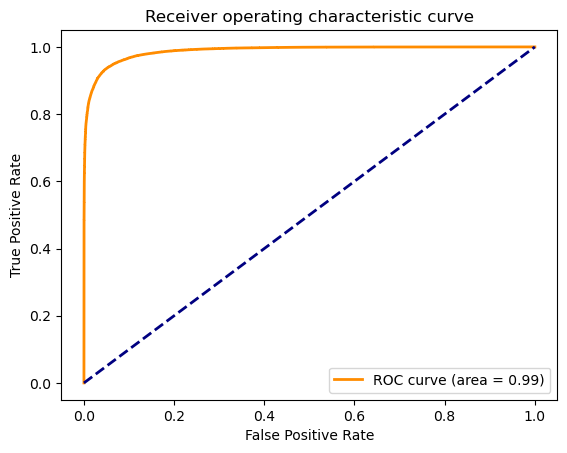

In [13]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

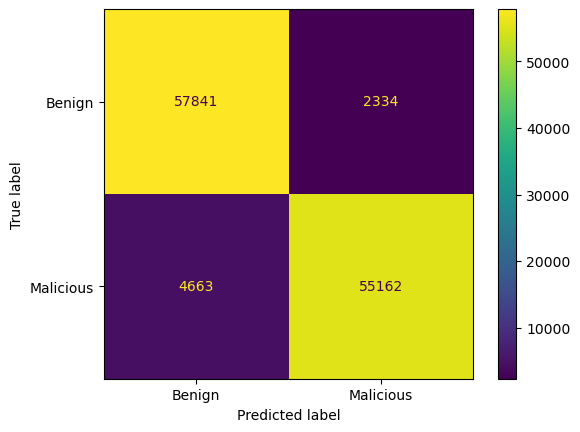

In [14]:
cm = confusion_matrix(y_val, y_pred[:, 1] > 0.6)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
disp.plot()

In [15]:
report = classification_report(y_val, y_pred[:, 1] >= 0.6, target_names=['Benign', 'Malicious'], output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers='keys', tablefmt='psql'))

+--------------+-------------+----------+------------+---------------+
|              |   precision |   recall |   f1-score |       support |
|--------------+-------------+----------+------------+---------------|
| Benign       |    0.925397 | 0.961213 |   0.942965 |  60175        |
| Malicious    |    0.959406 | 0.922056 |   0.94036  |  59825        |
| accuracy     |    0.941692 | 0.941692 |   0.941692 |      0.941692 |
| macro avg    |    0.942401 | 0.941635 |   0.941663 | 120000        |
| weighted avg |    0.942352 | 0.941692 |   0.941666 | 120000        |
+--------------+-------------+----------+------------+---------------+


### Bloom Filter
---

Our bloom filter uses the MMH3 hash function.  
It stores the bitmask to the numpy array using a boolean type, in such way, we are saving a lot of memory.  
The filter calculates by itself the size of the bitmask and the number of hash functions.  
The filter can save the bitmask and the metadata to a backup file and load it if needed.  
We're using loading from the file in the antivirus class.

In [16]:
class BloomFilter:

    def __init__(self, size=400000, eps=0.01, seed=42, file_path=None):
        if file_path is not None:
            self.load_filter_from_file(file_path)
        else:
            self.eps = eps
            self.size = size
            self.seed = seed
            self.m = self.__get_size_of_bitmask()
            self.k = self.__get_number_of_hash_functions()
            self.bitmask = np.zeros(self.m, dtype=bool)
            np.random.seed(self.seed)
            self.random_seeds = np.random.choice(range(0, 1000), size=self.k, replace=False)
            self.__generate_hash_function()

    def __get_number_of_hash_functions(self):
        return -int(np.ceil(np.log2(self.eps)))

    def __get_size_of_bitmask(self):
        return -int(np.ceil(self.size * np.log(self.eps) / np.log(2) ** 2))

    def __generate_hash_function(self):
        self.hash_functions = [lambda x, seed=self.random_seeds[i]: mmh3.hash(x, seed) for i in range(self.k)]

    def add(self, input_str):
        for hash_function in self.hash_functions:
            hash_val = hash_function(input_str)
            self.bitmask[hash_val % self.m] = True

    def add_from_file(self, file_path):
        with open(file_path, 'r') as file:
            for line in file:
                if line.strip():
                    self.add(line.strip())

    def check(self, input_str):
        for hash_function in self.hash_functions:
            hash_val = hash_function(input_str)
            if not self.bitmask[hash_val % self.m]:
                return False

        return True

    def get_bitmask(self):
        return self.bitmask

    def load_filter_from_file(self, file_path):
        try:
            file = tarfile.open(file_path, 'r:gz')
            file.extractall('./tmp')
            file.close()
            self.bitmask = np.load('./tmp/bitmask.npy')
            with open('./tmp/metadata.json', 'r') as f:
                meta = json.load(f)
                self.size = meta['size']
                self.eps = meta['eps']
                self.seed = meta['seed']
                self.m = meta['m']
                self.k = meta['k']
                self.random_seeds = np.array(meta['seeds'])

            self.__generate_hash_function()
            shutil.rmtree('./tmp')
        except Exception as e:
            print(e)

    def save_filter_to_file(self):
        np.save('bitmask.npy', self.bitmask)
        meta = {
            'size': self.size,
            'eps': self.eps,
            'seed': self.seed,
            'm': self.m,
            'k': self.k,
            'seeds': self.random_seeds.tolist()
        }
        with open('metadata.json', 'w') as f:
            json.dump(meta, f)

        with tarfile.open('filter.tgz', 'w:gz') as tar:
            tar.add('bitmask.npy')
            tar.add('metadata.json')

        os.remove('bitmask.npy')
        os.remove('metadata.json')

Create a filter.  
Make sure that you have the `task1_malicious_sha256_ember.txt` file before running.

In [17]:
# Create the bloom filter

filename = "task1_malicious_sha256_ember.txt"
c = 0
eps = 0.01
with open(filename, "r") as f:
    c = sum(1 for line in f if line.strip())

bloom_filter = BloomFilter(c, eps)
bloom_filter.add_from_file(filename)

In [18]:
# Save to file for later use in the AntiVirus
bloom_filter.save_filter_to_file()

In [19]:
# Bitmask memory usage
print(f'Bitmask memory usage: {bloom_filter.get_bitmask().nbytes / 1024 / 1024:.2f} MB')

Bitmask memory usage: 3.66 MB


### Feature extractor
---

We're using the Ember's feature extractor to parse files for the AntiVirus.  
Since Ember has a lot of bugs, sometimes it fails to parse files when running on windows machine, when running in Colab it works well.

In [20]:
class FeatureExtractor(ember.PEFeatureExtractor):
    def raw_features(self, bytez):
        try:
            lief_binary = lief.PE.parse(list(bytez))
        except Exception as e:
            print("lief error: ", str(e))
            raise e

        features = {"sha256": hashlib.sha256(bytez).hexdigest()}
        features.update({fe.name: fe.raw_features(bytez, lief_binary) for fe in self.features})
        return features

### AntiVirus Class
---

The AntiVirus receives the model and filters the backup file in the constructor.  
The function that should be called to start the antivirus is `start()`.  
If one of the backup files does not exist, it will raise an Exception, so make sure to run all previous cells.
The antivirus has two check functions, one receives a row with features, and the second `check_exe` receives a path to the file that should be checked (Note: as explained in the feature extractor section - this option can crush the kernel, Ember fix needed).  

In [21]:
class AntiVirus:
    def __init__(self, filter_update_file='filter.tgz', pretrained_model_path='model.pickle', precision=0.6, model_log_lvl=logging.INFO):
        self.pretrained_model_path = pretrained_model_path
        self.precision = precision
        self.model = None
        self.filter = None
        self.model_log_lvl = model_log_lvl
        self.filter_update_file = filter_update_file
        self.extractor = FeatureExtractor()

    def __preprocess(self, X):
        df = pd.json_normalize(X)
        df.insert(len(df), 'section_len', [len(str(X['section']))])
        df.insert(len(df), 'imports_len', [len(str(X['imports']))])
        df.insert(len(df), 'exports_len', [len(str(X['exports']))])
        return df

    def start(self):
        if os.path.exists(self.pretrained_model_path) and os.path.exists(self.filter_update_file):
            self.model = Model(pretrained_model_path=self.pretrained_model_path, precision=self.precision, log_lvl=self.model_log_lvl)
            self.model.load_model()
            self.filter = BloomFilter(file_path=self.filter_update_file)
        else:
            raise ValueError("pretrained_model_path and filter_update_file must be provided")

    def check(self, X):
        X_preprocessed = self.__preprocess(X)
        result = self.model.predict(X_preprocessed)
        if result:
            return True
        else:
            return self.filter.check(X["sha256"])

    def check_exe(self, path):
        binary = open(path, "rb").read()
        features = self.extractor.raw_features(binary)
        return self.check(features)

In [22]:
av = AntiVirus(filter_update_file="filter.tgz", precision=0.8, pretrained_model_path="model.pickle")

In [23]:
av.start()

#### Test some random rows from the test file

In [24]:
import time
times = []

test_file = os.path.join(data_dir, 'test_features.jsonl')
lines = []
prediction = None
labels = ['Benign', 'Malicious']

if os.path.exists(test_file):
    with open(test_file, "r") as f:
        for line in f:
            data = json.loads(line)
            lines.append(data)

# Selecting random 10 samples
lines = np.random.choice(lines, 10, replace=False)
for l in lines:
    print(f"Checking {l['sha256']}...")
    start = time.time()
    result = av.check(l)
    end = time.time()
    times.append(end - start)
    print(f"Is file malicious: {result}, real label: {labels[l['label']]}")
    print()

print(f"Average time per check: {np.mean(times) * 1000:.2f} ms")

Checking fc6b6bc15e9dedab5ca2a1cc8e82fd19dd18fe85f8efd82a356343cc59cb4f98...
Is file malicious: False, real label: Benign

Checking 4bdc63196651f7355d381bdbd52481f73b3b763e48d97846115716a7602d44d9...
Is file malicious: True, real label: Malicious

Checking ece760dcb429084c2ac75f7cd00fdd362025e15f17e53e181a8a1ee5d51b3608...
Is file malicious: False, real label: Benign

Checking 805617cbc13d195b2f05dc6f271b1d957b485faab33ae9bc64b5b1370180d548...
Is file malicious: False, real label: Benign

Checking ed58e2de1edb31725ab7b8618b8fe5e1dfa0e5a3603f2fc3bc6a9b93cd93e7d8...
Is file malicious: True, real label: Malicious

Checking af8faafe3a39b0073745d29d5697a795eb93d9ba1d45d7765b598bce0fb8d2d1...
Is file malicious: True, real label: Malicious

Checking 4412d24dbe034ad4d94d9e6285bf5899c7d2f3d2a55d11db62c71e0d98271d20...
Is file malicious: True, real label: Malicious

Checking 89a7132b0a2b211b79db7ffac063033d7234462e710ee59a01d144fa032ed582...
Is file malicious: True, real label: Malicious

Checki